# Email Campaign Simulation with Confounding

## 🎯 Learning Objectives

In this notebook, we will:

1. **Understand Confounding**: Learn what confounding is and why it matters in causal inference
2. **Realistic Simulation**: Explore a realistic email marketing simulation where assignment is **NOT random**
3. **True Causal Effect**: See how emails truly affect purchase behavior
4. **Selection Bias**: Demonstrate the bias in naive comparisons
5. **Setup for Causal Inference**: Prepare for methods to correct for confounding

---

## 📚 Background: The Problem of Confounding

In the real world, **email campaigns are not sent randomly**. Companies target customers based on:
- Recent purchase history
- Customer value
- Engagement levels
- Risk of churning

This creates **CONFOUNDING** - variables that affect both:
1. **Treatment assignment** (who gets emails)
2. **Outcome** (who makes purchases)

If we compare customers who received emails vs. those who didn't, we're comparing **different types of customers**, not testing the causal effect of emails!

### The Fundamental Problem of Causal Inference
We can never observe both states for the same customer:
- ✅ Customer **received** email → purchased
- ❌ Customer **did not receive** email → ? (counterfactual)

Without random assignment, we can't know the true counterfactual.

---

## 🔬 Simulation Design

Our simulation creates **realistic confounding** by making email assignment depend on customer characteristics.

### Email Assignment Rules (Confounding)

Customers are more likely to receive emails if they are:
- **Recent purchasers** (bought in last 2 weeks): 60% chance
- **Frequent buyers** (>10 past purchases): 50% chance  
- **High-value customers** (AOV > £20): 55% chance
- **Lapsed customers** (30-60 days since purchase): 40% chance
- **Base rate** for everyone: 15% chance

### True Causal Effect

Emails **truly increase** purchase probability:
- **Base effect**: +10 percentage points
- **Interaction**: Stronger effect for medium RFM scores (8-12): +5 pp
- **Heterogeneity**: Weaker for high RFM, negative for low RFM
- **Noise**: Random variation in effects

---


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported")

✅ Libraries imported


## 📊 Load and Explore the Panel Data

In [2]:
# Load the customer-week panel dataset
panel_df = pd.read_csv('../data/processed/customer_week_panel.csv')

print("="*60)
print("PANEL DATASET OVERVIEW")
print("="*60)
print(f"Shape: {panel_df.shape}")
print(f"Unique customers: {panel_df['CustomerID'].nunique():,}")
print(f"Time period: {panel_df['week_number'].min()} to {panel_df['week_number'].max()} weeks")
print(f"Purchase rate: {panel_df['purchase_this_week'].mean():.1%}")

print("\nColumns:")
for i, col in enumerate(panel_df.columns, 1):
    print(f"  {i:2d}. {col}")

PANEL DATASET OVERVIEW
Shape: (137888, 13)
Unique customers: 4,213
Time period: 1 to 53 weeks
Purchase rate: 11.4%

Columns:
   1. CustomerID
   2. week_number
   3. week_start
   4. purchase_this_week
   5. revenue_this_week
   6. days_since_last_purchase
   7. total_past_purchases
   8. avg_order_value
   9. customer_tenure_weeks
  10. rfm_score
  11. quantity_this_week
  12. orders_this_week
  13. transactions_this_week


## 🎲 Run the Email Campaign Simulation

Let's run the simulation to create realistic confounding and true causal effects.

In [3]:
# Import the simulation function
import sys
sys.path.append('../src/data/')
from simulate_email_campaigns import simulate_email_campaigns, save_simulation_results

# Run simulation
simulated_data, ground_truth = simulate_email_campaigns(panel_df, random_seed=42)

print("\n" + "="*60)
print("SIMULATION COMPLETE!")
print("="*60)

EMAIL CAMPAIGN SIMULATION WITH CONFOUNDING

Random Seed: 42
Input Panel Shape: (137888, 13)

GROUND TRUTH (for validation later)
Base Email Effect: +10.0 percentage points
Interaction Effect (RFM 8-12): +5.0 pp
Interaction Effect (RFM >12): +2.0 pp
Interaction Effect (RFM <8): -3.0 pp

STEP 1: Email Assignment (CONFOUNDED)

Calculating email assignment probabilities...
Confounding rules:
  - Recent purchasers (≤14 days): +60%
  - Frequent buyers (>10 purchases): +50%
  - High-value customers (AOV > £20): +55%
  - Lapsed customers (30-60 days): +40%
  - Base rate: 15%

Actual email send rate: 81.7%

Email assignment by characteristics:
  Recent buyers: 95.1%
  Frequent buyers: 95.0%
  High AOV: 81.8%
  Lapsed: 95.0%
  Other: 18.2%

STEP 2: True Purchase Probability (with causal effect)

Calculating purchase probabilities with causal effect...
Sampling actual purchases...

Observed purchase rate: 31.7%

Observed purchase rates by email receipt (CONFOUNDED):
  No email: 18.6% (n=25,166)
 

## 📈 Analyze the Confounding

Let's examine how email assignment is confounded with customer characteristics.

In [4]:
# Save simulation results
output_path, gt_path, summary_path = save_simulation_results(
    simulated_data, ground_truth, '../data/processed'
)

print("\n" + "="*60)
print("CONFOUNDING ANALYSIS")
print("="*60)


✅ Simulated dataset saved to: ../data/processed/simulated_email_campaigns.csv
✅ Ground truth saved to: ../data/processed/ground_truth.json
✅ Summary statistics saved to: ../data/processed/simulation_summary.json

CONFOUNDING ANALYSIS


In [5]:
# 1. Email assignment rates by customer characteristics
print("\n1. Email Assignment Rates by Customer Segments:")
print("-"*60)

# Recent purchasers
recent = simulated_data['days_since_last_purchase'] <= 14
email_rate_recent = simulated_data[recent]['received_email'].mean()
print(f"   Recent purchasers (≤14 days): {email_rate_recent:.1%}")

# Frequent buyers
frequent = simulated_data['total_past_purchases'] > 10
email_rate_frequent = simulated_data[frequent]['received_email'].mean()
print(f"   Frequent buyers (>10 purchases): {email_rate_frequent:.1%}")

# High AOV
high_aov = simulated_data['avg_order_value'] > 20
email_rate_aov = simulated_data[high_aov]['received_email'].mean()
print(f"   High-value customers (AOV > £20): {email_rate_aov:.1%}")

# Lapsed customers
lapsed = (simulated_data['days_since_last_purchase'] >= 30) & (simulated_data['days_since_last_purchase'] <= 60)
email_rate_lapsed = simulated_data[lapsed]['received_email'].mean()
print(f"   Lapsed customers (30-60 days): {email_rate_lapsed:.1%}")

# Everyone else
other = ~recent & ~frequent & ~high_aov & ~lapsed
email_rate_other = simulated_data[other]['received_email'].mean()
print(f"   Other customers: {email_rate_other:.1%}")

print("\n→ Email assignment is HIGHLY SELECTIVE!")
print("  → Customers who receive emails are fundamentally different")
print("  → This is CONFOUNDING!")


1. Email Assignment Rates by Customer Segments:
------------------------------------------------------------
   Recent purchasers (≤14 days): 95.1%
   Frequent buyers (>10 purchases): 95.0%
   High-value customers (AOV > £20): 81.8%
   Lapsed customers (30-60 days): 95.0%
   Other customers: 18.2%

→ Email assignment is HIGHLY SELECTIVE!
  → Customers who receive emails are fundamentally different
  → This is CONFOUNDING!


In [6]:
# 2. Correlation between email assignment and customer characteristics
print("\n2. Correlation Between Email Receipt and Customer Traits:")
print("-"*60)

features = ['rfm_score', 'days_since_last_purchase', 'total_past_purchases',
           'avg_order_value', 'customer_tenure_weeks']

correlations = {}
for feature in features:
    corr = simulated_data['received_email'].corr(simulated_data[feature])
    correlations[feature] = corr
    print(f"   corr(received_email, {feature:30s}): {corr:+6.3f}")

print("\n→ All correlations ≠ 0, confirming CONFOUNDING")


2. Correlation Between Email Receipt and Customer Traits:
------------------------------------------------------------
   corr(received_email, rfm_score                     ): +0.111
   corr(received_email, days_since_last_purchase      ): -0.199
   corr(received_email, total_past_purchases          ): +0.081
   corr(received_email, avg_order_value               ): +0.013
   corr(received_email, customer_tenure_weeks         ): -0.059

→ All correlations ≠ 0, confirming CONFOUNDING


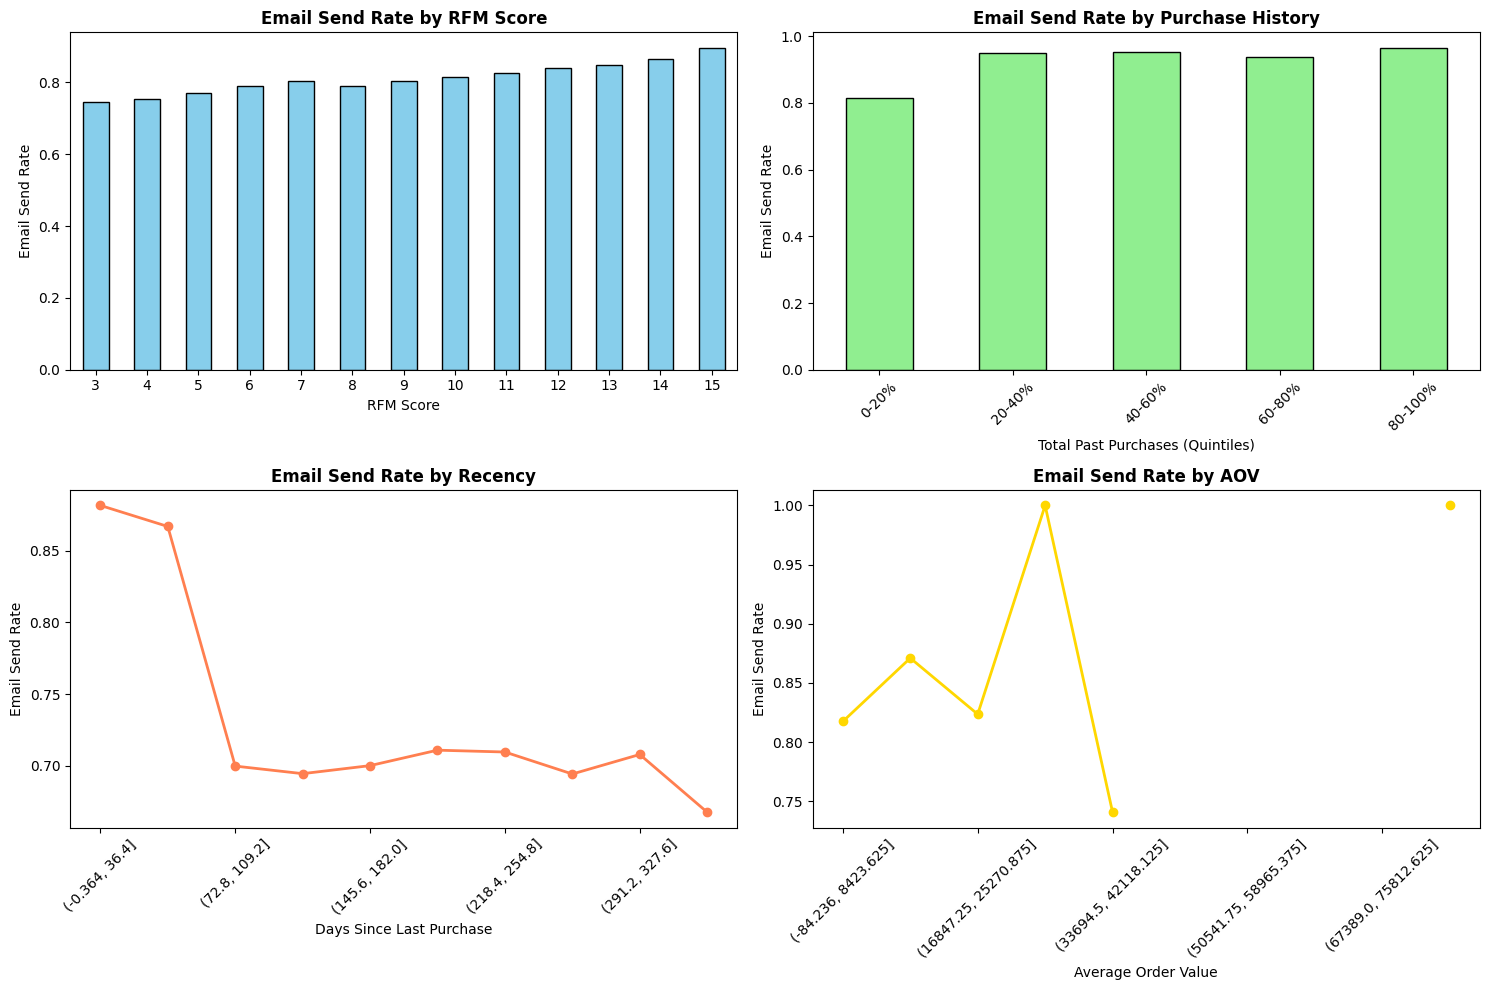


→ These plots show CLEAR CONFOUNDING patterns
  → Email assignment depends heavily on customer characteristics


In [7]:
# 3. Visualize confounding
plt.figure(figsize=(15, 10))

# Plot 1: Email rate by RFM score
plt.subplot(2, 2, 1)
rfm_email_rates = simulated_data.groupby('rfm_score')['received_email'].mean()
rfm_email_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Email Send Rate by RFM Score', fontweight='bold')
plt.xlabel('RFM Score')
plt.ylabel('Email Send Rate')
plt.xticks(rotation=0)

# Plot 2: Email rate by purchase history
plt.subplot(2, 2, 2)
purchase_bins = pd.cut(simulated_data['total_past_purchases'], bins=5, labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
purchase_email_rates = simulated_data.groupby(purchase_bins)['received_email'].mean()
purchase_email_rates.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Email Send Rate by Purchase History', fontweight='bold')
plt.xlabel('Total Past Purchases (Quintiles)')
plt.ylabel('Email Send Rate')
plt.xticks(rotation=45)

# Plot 3: Days since last purchase vs email rate
plt.subplot(2, 2, 3)
recency_bins = pd.cut(simulated_data['days_since_last_purchase'], bins=10)
recency_email_rates = simulated_data.groupby(recency_bins)['received_email'].mean()
recency_email_rates.plot(kind='line', marker='o', color='coral', linewidth=2)
plt.title('Email Send Rate by Recency', fontweight='bold')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Email Send Rate')
plt.xticks(rotation=45)

# Plot 4: Average order value vs email rate
plt.subplot(2, 2, 4)
aov_bins = pd.cut(simulated_data['avg_order_value'], bins=10)
aov_email_rates = simulated_data.groupby(aov_bins)['received_email'].mean()
aov_email_rates.plot(kind='line', marker='o', color='gold', linewidth=2)
plt.title('Email Send Rate by AOV', fontweight='bold')
plt.xlabel('Average Order Value')
plt.ylabel('Email Send Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n→ These plots show CLEAR CONFOUNDING patterns")
print("  → Email assignment depends heavily on customer characteristics")

## ⚖️ Naive Analysis: The Biased Estimate

What happens if we **naively compare** customers who received emails vs. those who didn't?

In [8]:
print("="*60)
print("NAIVE COMPARISON (INCORRECT)")
print("="*60)

# Calculate naive comparison
no_email = simulated_data[~simulated_data['received_email']]
received_email = simulated_data[simulated_data['received_email']]

purchase_rate_no_email = no_email['purchased_this_week_observed'].mean()
purchase_rate_email = received_email['purchased_this_week_observed'].mean()
naive_effect = purchase_rate_email - purchase_rate_no_email

print(f"\nPurchase rates:")
print(f"  No email: {purchase_rate_no_email:.1%} (n={len(no_email):,})")
print(f"  Received email: {purchase_rate_email:.1%} (n={len(received_email):,})")
print(f"\nNaive observed effect: {naive_effect:.1%}")

print("\n" + "="*60)
print("PROBLEM: This is BIASED!")
print("="*60)
print("Why? Because:")
print("  1. Customers who get emails are already more likely to buy")
print("     (recent buyers, frequent buyers, high-value)")
print("  2. We're comparing DIFFERENT TYPES of customers")
print("  3. This is NOT a valid test of email effectiveness")

NAIVE COMPARISON (INCORRECT)

Purchase rates:
  No email: 18.6% (n=25,166)
  Received email: 34.7% (n=112,722)

Naive observed effect: 16.0%

PROBLEM: This is BIASED!
Why? Because:
  1. Customers who get emails are already more likely to buy
     (recent buyers, frequent buyers, high-value)
  2. We're comparing DIFFERENT TYPES of customers
  3. This is NOT a valid test of email effectiveness


In [9]:
# Show that the email group has higher baseline characteristics
print("\nCustomer characteristics by email receipt:")
print("-"*60)

for feature in ['rfm_score', 'total_past_purchases', 'avg_order_value', 'days_since_last_purchase']:
    no_email_mean = no_email[feature].mean()
    email_mean = received_email[feature].mean()
    difference = email_mean - no_email_mean
    
    print(f"\n{feature}:")
    print(f"  No email: {no_email_mean:.2f}")
    print(f"  Email: {email_mean:.2f}")
    print(f"  Difference: {difference:+.2f} ← EMAIL GROUP IS BETTER!")

print("\n" + "="*60)
print("✓ EMAIL GROUP HAS HIGHER BASELINE PURCHASE PROBABILITY")
print("✓ NAIVE COMPARISON DOUBLE-COUNTS THIS ADVANTAGE")
print("="*60)


Customer characteristics by email receipt:
------------------------------------------------------------

rfm_score:
  No email: 8.66
  Email: 9.76
  Difference: +1.10 ← EMAIL GROUP IS BETTER!

total_past_purchases:
  No email: 2.06
  Email: 2.74
  Difference: +0.67 ← EMAIL GROUP IS BETTER!

avg_order_value:
  No email: 412.74
  Email: 445.32
  Difference: +32.58 ← EMAIL GROUP IS BETTER!

days_since_last_purchase:
  No email: 99.42
  Email: 61.69
  Difference: -37.73 ← EMAIL GROUP IS BETTER!

✓ EMAIL GROUP HAS HIGHER BASELINE PURCHASE PROBABILITY
✓ NAIVE COMPARISON DOUBLE-COUNTS THIS ADVANTAGE


## 🎯 True Causal Effect (What We Want to Know)

Now let's see the **TRUE** causal effect of emails, calculated using counterfactuals.

In [10]:
print("="*60)
print("TRUE CAUSAL EFFECT")
print("="*60)

# Load ground truth
with open('../data/processed/ground_truth.json', 'r') as f:
    gt = json.load(f)

print(f"\nGround truth (what we know):")
print(f"  Base email effect: +{gt['base_email_effect']*100:.1f} percentage points")
print(f"  Interaction (medium RFM): +{gt['interaction_effect_medium_rfm']*100:.1f} pp")
print(f"  Interaction (high RFM): +{gt['interaction_effect_high_rfm']*100:.1f} pp")
print(f"  Interaction (low RFM): {gt['interaction_effect_low_rfm']*100:.1f} pp")

# Calculate individual treatment effects
# (What would happen to each customer if they got/didn't get email)
ate = simulated_data['individual_treatment_effect'].mean()

print(f"\nCalculated Average Treatment Effect (ATE): {ate:.1%}")
print(f"Expected ATE from ground truth: {gt['base_email_effect']:.1%}")
print(f"\n✓ Close match! This is the TRUE causal effect.")

# Heterogeneous effects by RFM
print("\n" + "="*60)
print("HETEROGENEOUS EFFECTS (by RFM Score)")
print("="*60)

for rfm_range, label in [(range(3, 8), 'Low (3-7)'),
                         (range(8, 13), 'Medium (8-12)'),
                         (range(13, 16), 'High (13-15)')]:
    mask = simulated_data['rfm_score'].isin(rfm_range)
    if mask.sum() > 0:
        effect = simulated_data[mask]['individual_treatment_effect'].mean()
        count = mask.sum()
        print(f"\n{label}: {effect:.1%} (n={count:,})")

print("\n→ Email effect is STRONGEST for medium RFM scores")
print("→ This makes business sense: engaged but not yet loyal customers")

TRUE CAUSAL EFFECT

Ground truth (what we know):
  Base email effect: +10.0 percentage points
  Interaction (medium RFM): +5.0 pp
  Interaction (high RFM): +2.0 pp
  Interaction (low RFM): -3.0 pp

Calculated Average Treatment Effect (ATE): 9.5%
Expected ATE from ground truth: 10.0%

✓ Close match! This is the TRUE causal effect.

HETEROGENEOUS EFFECTS (by RFM Score)

Low (3-7): 5.4% (n=45,154)

Medium (8-12): 12.2% (n=53,082)

High (13-15): 10.5% (n=39,652)

→ Email effect is STRONGEST for medium RFM scores
→ This makes business sense: engaged but not yet loyal customers


In [11]:
# Compare naive vs true effect
print("\n" + "="*60)
print("COMPARISON: NAIVE vs TRUE EFFECT")
print("="*60)

print(f"\nNaive observed effect: {naive_effect:.1%}")
print(f"True causal effect: {ate:.1%}")
print(f"\nBias: {naive_effect - ate:.1%}")

if naive_effect > ate:
    print(f"\n✓ Naive effect is OVERESTIMATED by {naive_effect - ate:.1%}")
    print("  → Because email group had higher baseline purchase probability")
else:
    print(f"\n✓ Naive effect is UNDERESTIMATED by {ate - naive_effect:.1%}")
    print("  → Because email group had lower baseline purchase probability")

print("\n" + "="*60)
print("✓ CONFIRMATION: CONFOUNDING CREATES BIAS!")
print("="*60)


COMPARISON: NAIVE vs TRUE EFFECT

Naive observed effect: 16.0%
True causal effect: 9.5%

Bias: 6.5%

✓ Naive effect is OVERESTIMATED by 6.5%
  → Because email group had higher baseline purchase probability

✓ CONFIRMATION: CONFOUNDING CREATES BIAS!


## 📊 Visualize the True vs Naive Effects

Let's create visualizations to see the difference between naive and true estimates.

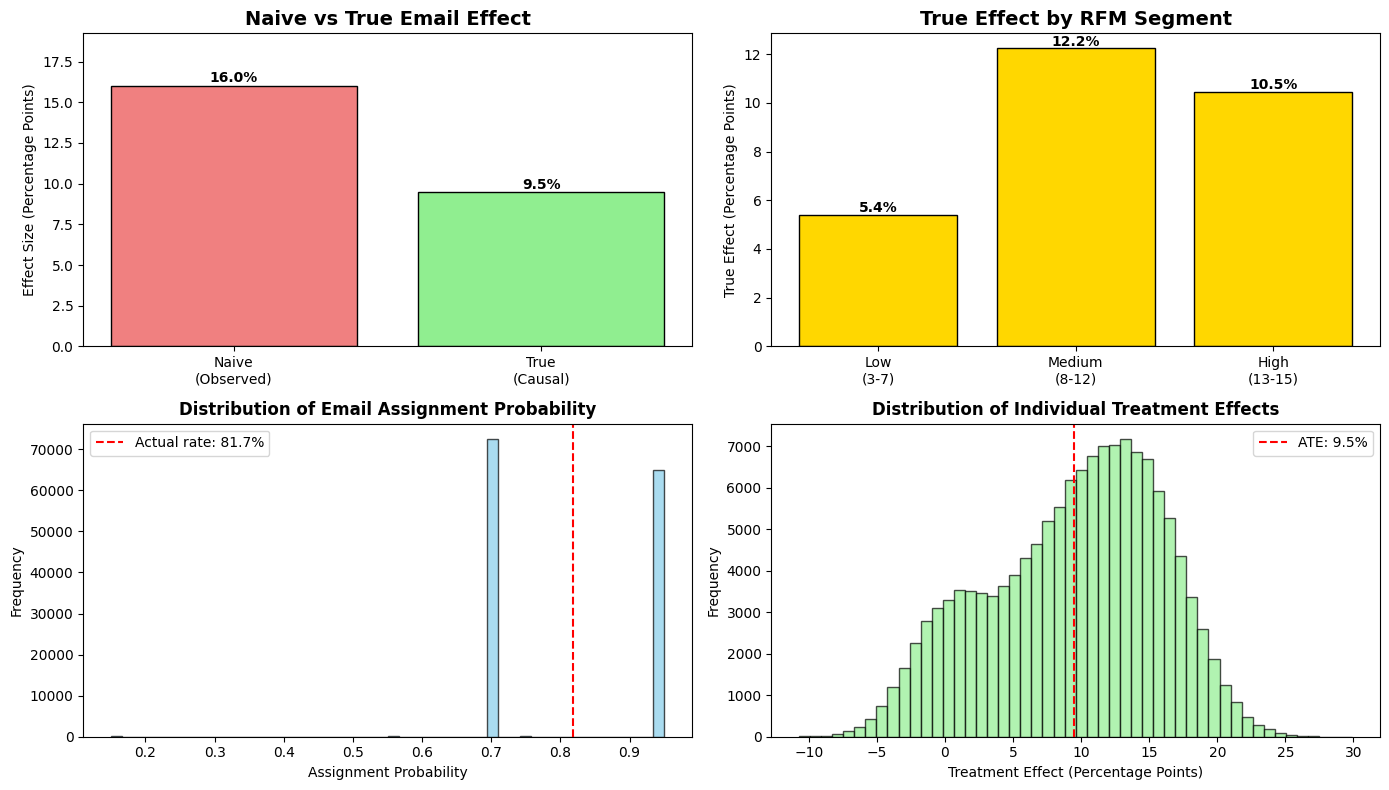

In [12]:
# Create comparison plot
plt.figure(figsize=(14, 8))

# Plot 1: Naive vs True overall effect
plt.subplot(2, 2, 1)
effects = ['Naive\n(Observed)', 'True\n(Causal)']
effect_values = [naive_effect*100, ate*100]
colors = ['lightcoral', 'lightgreen']
bars = plt.bar(effects, effect_values, color=colors, edgecolor='black')
plt.title('Naive vs True Email Effect', fontweight='bold', fontsize=14)
plt.ylabel('Effect Size (Percentage Points)')
for i, v in enumerate(effect_values):
    plt.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')
plt.ylim(0, max(effect_values) * 1.2)

# Plot 2: Effects by RFM segment
plt.subplot(2, 2, 2)
rfm_labels = ['Low\n(3-7)', 'Medium\n(8-12)', 'High\n(13-15)']
rfm_effects = []
for rfm_range in [range(3, 8), range(8, 13), range(13, 16)]:
    mask = simulated_data['rfm_score'].isin(rfm_range)
    if mask.sum() > 0:
        effect = simulated_data[mask]['individual_treatment_effect'].mean() * 100
        rfm_effects.append(effect)
    else:
        rfm_effects.append(0)

plt.bar(rfm_labels, rfm_effects, color='gold', edgecolor='black')
plt.title('True Effect by RFM Segment', fontweight='bold', fontsize=14)
plt.ylabel('True Effect (Percentage Points)')
for i, v in enumerate(rfm_effects):
    plt.text(i, v + 0.1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 3: Email assignment probability distribution
plt.subplot(2, 2, 3)
plt.hist(simulated_data['email_assignment_probability'], bins=50, 
         color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Email Assignment Probability', fontweight='bold')
plt.xlabel('Assignment Probability')
plt.ylabel('Frequency')
plt.axvline(simulated_data['received_email'].mean(), color='red', 
           linestyle='--', label=f"Actual rate: {simulated_data['received_email'].mean():.1%}")
plt.legend()

# Plot 4: Treatment effect distribution
plt.subplot(2, 2, 4)
plt.hist(simulated_data['individual_treatment_effect']*100, bins=50,
         color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Distribution of Individual Treatment Effects', fontweight='bold')
plt.xlabel('Treatment Effect (Percentage Points)')
plt.ylabel('Frequency')
plt.axvline(ate*100, color='red', linestyle='--', 
           label=f"ATE: {ate:.1%}")
plt.legend()

plt.tight_layout()
plt.show()

## 🔑 Key Takeaways

### 1. **Confounding is Everywhere in Marketing**
- Companies target customers based on predicted value
- This creates selection bias in all non-experimental data

### 2. **Naive Comparisons are Dangerous**
- Comparing email recipients vs non-recipients compares different customer types
- Overestimates or underestimates true causal effects
- Can lead to wrong business decisions

### 3. **The Solution: Causal Inference Methods**
- We need methods that account for confounding
- Options include:
  - **Propensity Score Matching**: Match similar customers
  - **Difference-in-Differences**: Use before/after changes
  - **Instrumental Variables**: Find quasi-random variation
  - **Regression Adjustment**: Control for confounding variables

### 4. **Heterogeneous Effects Matter**
- Email effects vary by customer segment
- Medium RFM customers respond best (engaged but not loyal)
- Personalized targeting can improve ROI

---

## 🚀 Next Steps

Now that we have a realistic simulation with confounding, we can:

1. **Test causal inference methods** on this simulated data
2. **Compare estimates** from different methods
3. **Validate against ground truth** (which we know)
4. **Apply to real data** with appropriate caution

### Notebook 3: Causal Inference Methods
We'll implement:
- Propensity Score Matching
- Inverse Probability Weighting
- Regression Adjustment
- Double Machine Learning

These will help us recover the true causal effect despite confounding!

---

## 📁 Files Created

- `simulated_email_campaigns.csv`: Full dataset with email assignments and outcomes
- `ground_truth.json`: True parameters for validation
- `simulation_summary.json`: Summary statistics

Use these files to practice causal inference methods!